<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Данные" data-toc-modified-id="Данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Описание-полей-данных" data-toc-modified-id="Описание-полей-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Описание полей данных</a></span></li></ul></li><li><span><a href="#Предподготовка-данных" data-toc-modified-id="Предподготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предподготовка данных</a></span><ul class="toc-item"><li><span><a href="#Графики" data-toc-modified-id="Графики-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Графики</a></span></li></ul></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Music genre prediction

## Описание проекта

Музыкальный стриминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Необходимо разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Данные

* `train.csv` - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* `test.csv` - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* `sample_submit.csv` - файл предсказаний в правильном формате.

### Описание полей данных

* `instance_id` - уникальный идентификатор трека
* `track_name` - название трека
* `acousticness` - акустичность 
* `danceability` - танцевальность
* `duration_ms` -продолжительность в милисекундах
* `energy` - энергичность
* `instrumentalness` - инструментальность
* `key` - базовый ключ (нота) произведения
* `liveness` - привлекательность
* `loudness` - громкость
* `mode` - указывает на модальность (мажорную или минорную) трека
* `speechiness` - выразительность
* `tempo` - темп
* `obtained_date` - дата загрузки в сервис
* `valence` - привлекательность произведения для пользователей сервиса
* `music_genre` - музыкальный жанр

## Предподготовка данных

Импортируем библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from collections import Counter
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from phik.report import plot_correlation_matrix
from phik import report
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import (cross_val_score, cross_validate, GridSearchCV, train_test_split, 
                                     RandomizedSearchCV, StratifiedKFold)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, StandardScaler, OneHotEncoder,
                                   MinMaxScaler, LabelEncoder, RobustScaler, PolynomialFeatures)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor

Загрузим данные в *data_train* и *data_test*

In [2]:
data_train = pd.read_csv('kaggle_music_genre_train.csv', index_col='instance_id')
data_test = pd.read_csv('kaggle_music_genre_test.csv', index_col='instance_id')

Выведем информацию о тестовых данных.

In [3]:
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 20394 entries, 25143.0 to 86375.0
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20394 non-null  object 
 1   acousticness      20394 non-null  float64
 2   danceability      20394 non-null  float64
 3   duration_ms       20394 non-null  float64
 4   energy            20394 non-null  float64
 5   instrumentalness  20394 non-null  float64
 6   key               19659 non-null  object 
 7   liveness          20394 non-null  float64
 8   loudness          20394 non-null  float64
 9   mode              19888 non-null  object 
 10  speechiness       20394 non-null  float64
 11  tempo             19952 non-null  float64
 12  obtained_date     20394 non-null  object 
 13  valence           20394 non-null  float64
 14  music_genre       20394 non-null  object 
dtypes: float64(10), object(5)
memory usage: 2.5+ MB


,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
instance_id,,,,,,,,,,,,,,,
25143.0,Highwayman,0.480000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
26091.0,Toes Across The Floor,0.243000,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
87888.0,First Person on Earth,0.228000,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
77021.0,No Te Veo - Digital Single,0.055800,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
20852.0,Chasing Shadows,0.227000,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
43934.0,Eskimo Blue Day - Remastered,0.102000,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,Blues
23450.0,Living On My Own,0.000234,0.655,218267.0,0.687,0.000024,A,0.0869,-11.789,Minor,0.0337,123.923,4-Apr,0.411,Rock
28380.0,Para Machuchar Meu Coracao,0.953000,0.591,309813.0,0.109,0.357000,D#,0.0921,-17.975,Major,0.0449,130.597,4-Apr,0.395,Jazz
70054.0,In the Mood,0.195000,0.647,283373.0,0.595,0.000118,A#,0.1290,-8.416,Minor,0.0336,73.478,4-Apr,0.546,Jazz


Проверим наличие пропусков.

In [4]:
data_train.isna().sum()

track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

Есть пропуски в графах key, mode и tempo.

Проверим уникальность индексов.

In [5]:
len(np.unique(np.array(data_train.index)))

20394

Количество уникальных интексов совпадает с общим количеством песен.

Посмотрим статистики.

In [6]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041
valence,20394.0,0.464588,0.243387,0.00000,0.27200,0.457000,0.653000,0.992


Проверим наличие явных дубликатов.

In [7]:
data_train.duplicated().sum()

1

Дубликаты найдены, удалим их.

In [8]:
data_train = data_train.drop_duplicates()
data_train.duplicated().sum()

0

Проверим наличие неявных дубликатов в названиях песен.

In [9]:
len(data_train['track_name'].unique())

18643

Названия некоторых песен повторяются, однако многие произведения имеют схожи названия, а так как в остальных параметрах дубликатов больше не наблюдается, то песни с дублирующими названиями удалять нельзя.

### Графики

Построим графики корреляций.

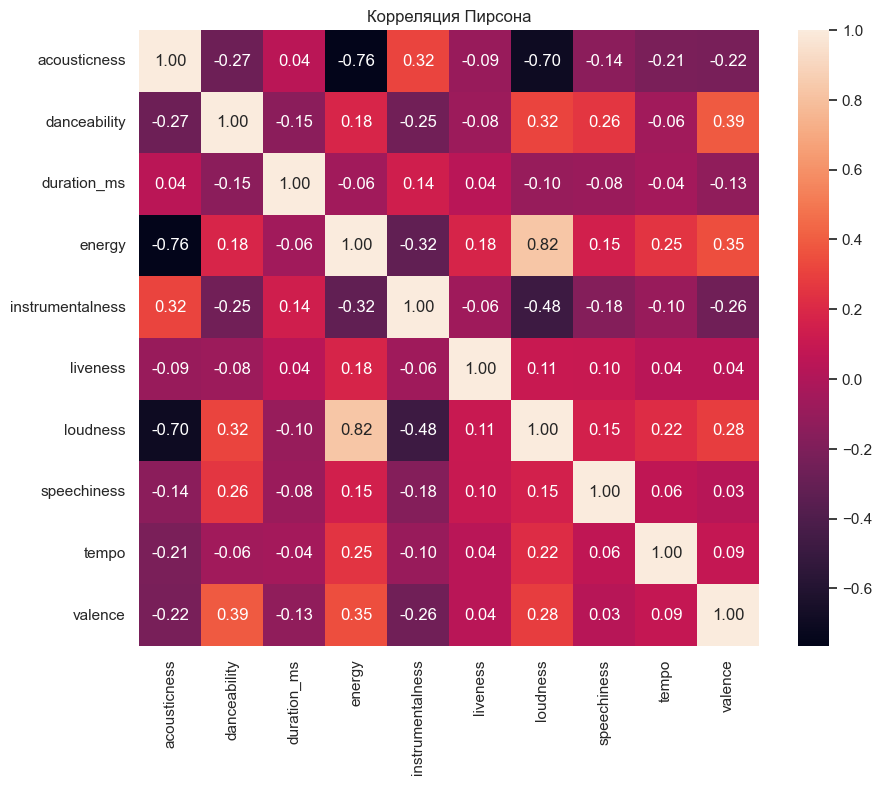

In [10]:
sns.set(rc={'figure.figsize':(10, 8)})
numeric_columns = data_train.columns[np.where(data_train.dtypes==np.number)]
sns.heatmap(data_train[numeric_columns].corr(), annot = True, fmt=".2f").set(title='Корреляция Пирсона')
plt.show()

Явно заметны следующие корреляции: acousticness заметно коррелирует с energy и loudness, energy очень существенно коррелирует с loudness, danceability довольно заметно коррелирует с energy и valence, таргет заметно коррелирует с loudness, energy, acousticness, danceability, instrumentalness.

Построим гистограммы распределения признаков для закрытия пропусков.

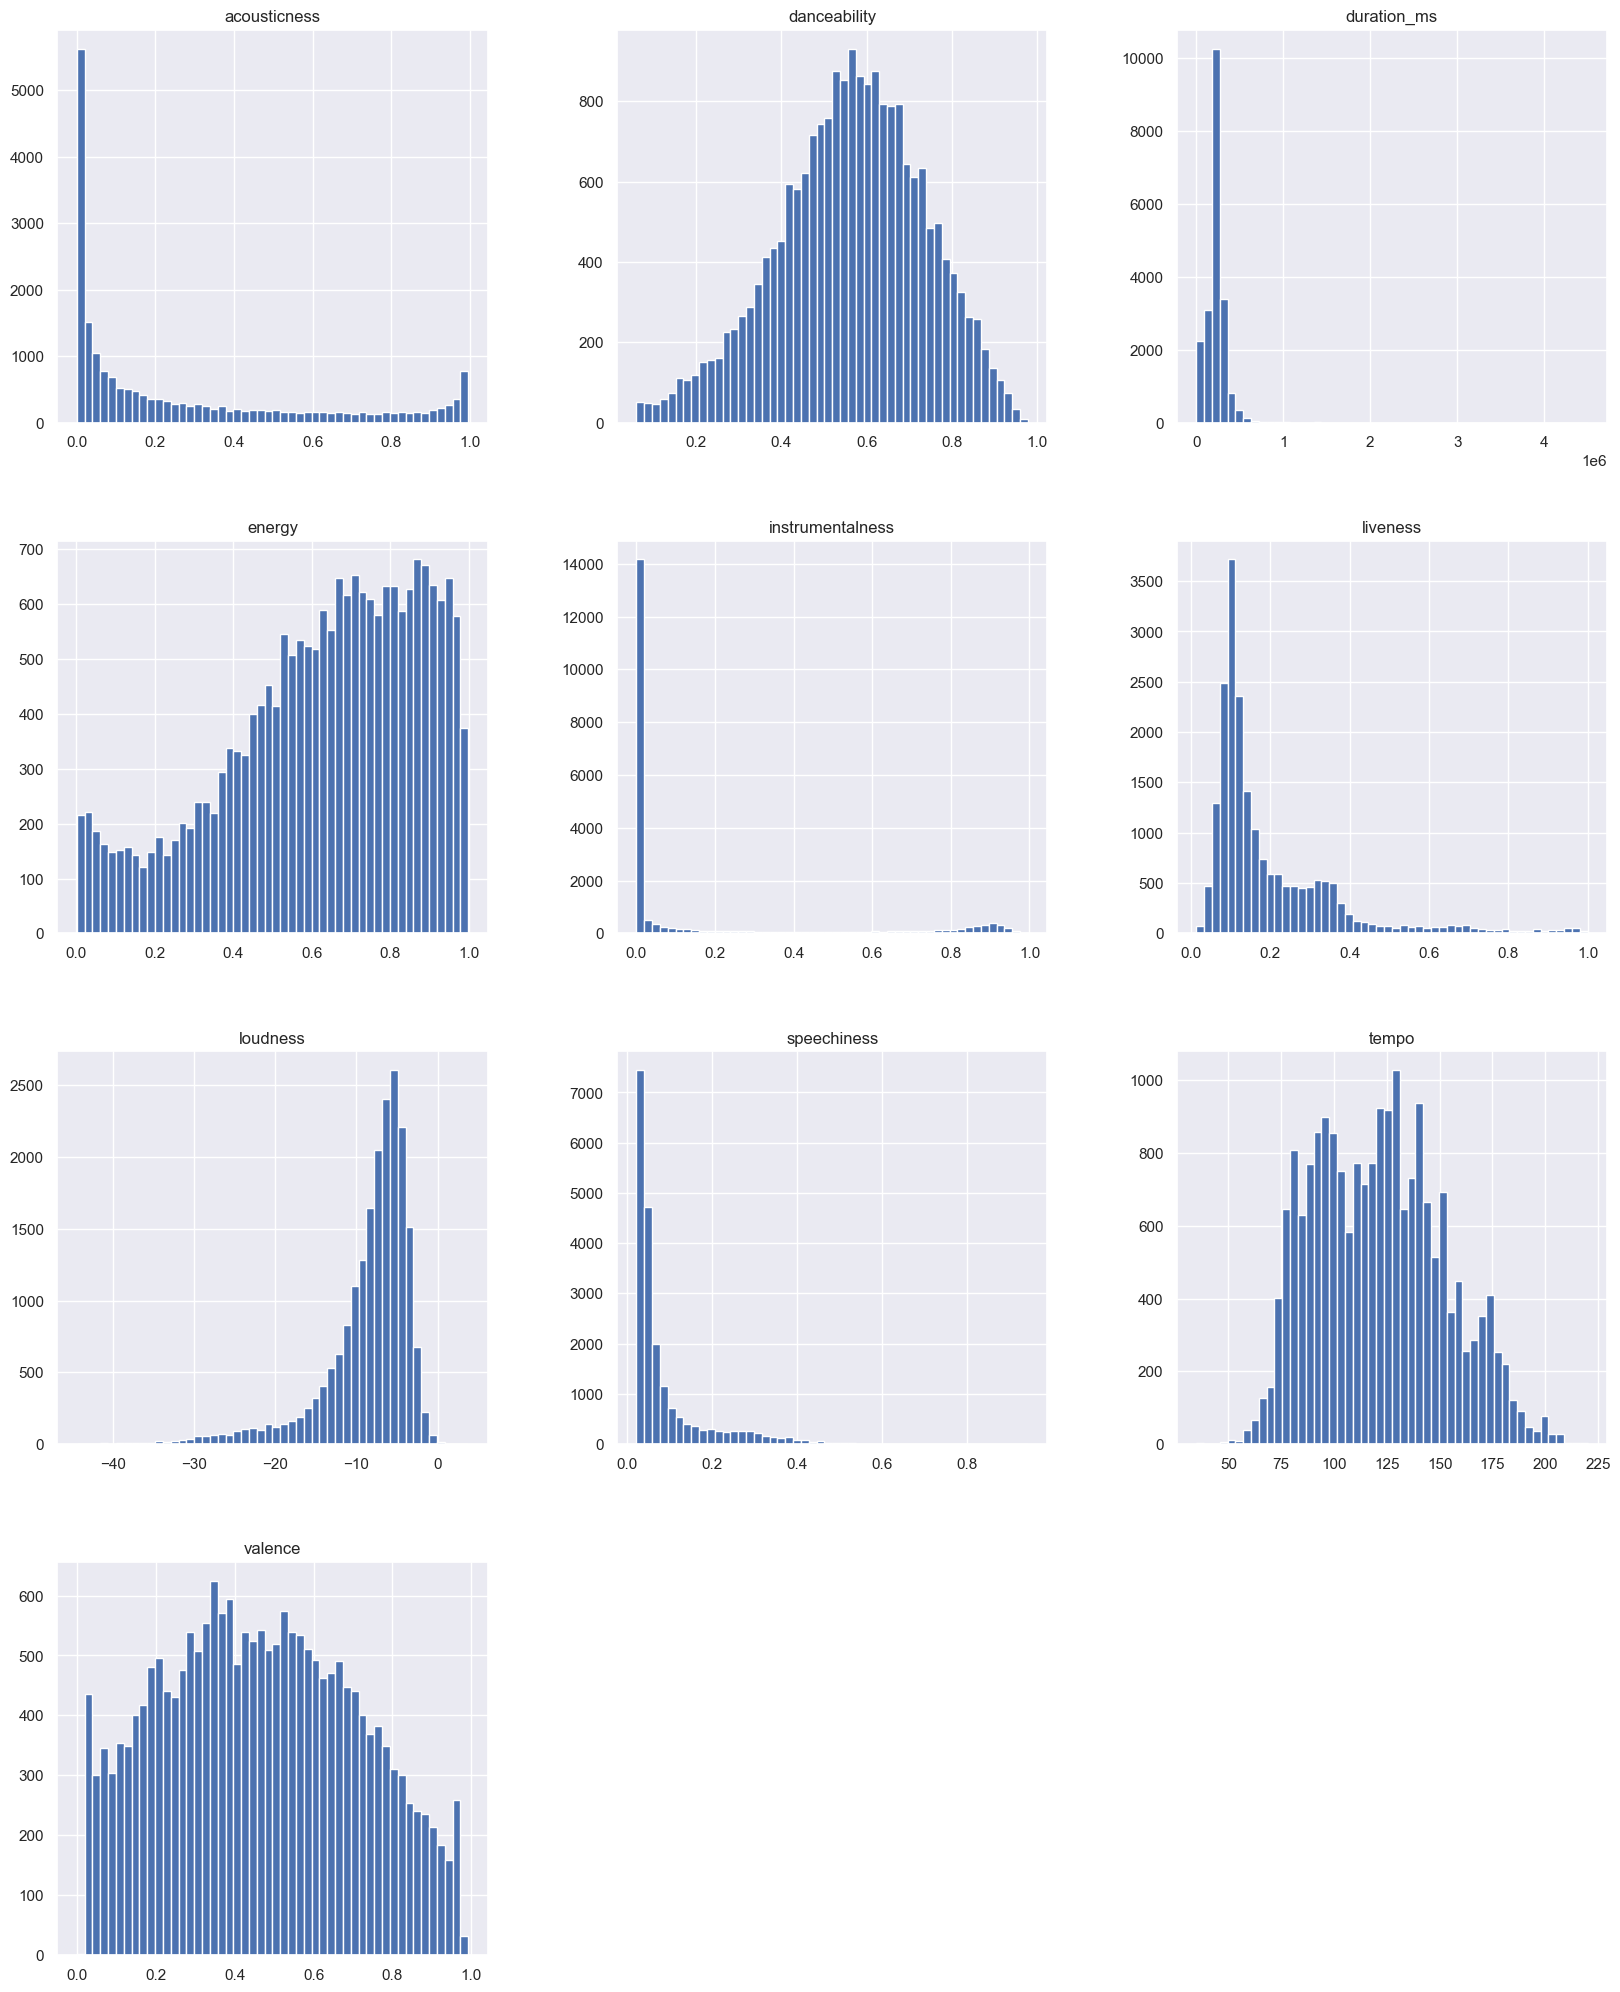

In [11]:
data_train.hist(figsize=(20, 25), bins = 50);

Распределение *tempo* нормальное, для закрытия пропусков воспользуемся медианой. Для устранения пропусков в *key* и *mode* используем значение `unknown`.

В остальном по графикам видно, что классы представлены неравномерно

In [12]:
data_train.fillna(value= {'key':'unknown', 'mode':'unknown', 'tempo':data_train['tempo'].median()}, inplace = True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 20393 entries, 25143.0 to 86375.0
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20393 non-null  object 
 1   acousticness      20393 non-null  float64
 2   danceability      20393 non-null  float64
 3   duration_ms       20393 non-null  float64
 4   energy            20393 non-null  float64
 5   instrumentalness  20393 non-null  float64
 6   key               20393 non-null  object 
 7   liveness          20393 non-null  float64
 8   loudness          20393 non-null  float64
 9   mode              20393 non-null  object 
 10  speechiness       20393 non-null  float64
 11  tempo             20393 non-null  float64
 12  obtained_date     20393 non-null  object 
 13  valence           20393 non-null  float64
 14  music_genre       20393 non-null  object 
dtypes: float64(10), object(5)
memory usage: 2.5+ MB


Выведем распределение композиций по жанрам.

Blues          2858
Alternative    2601
Electronic     2563
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64


<AxesSubplot:>

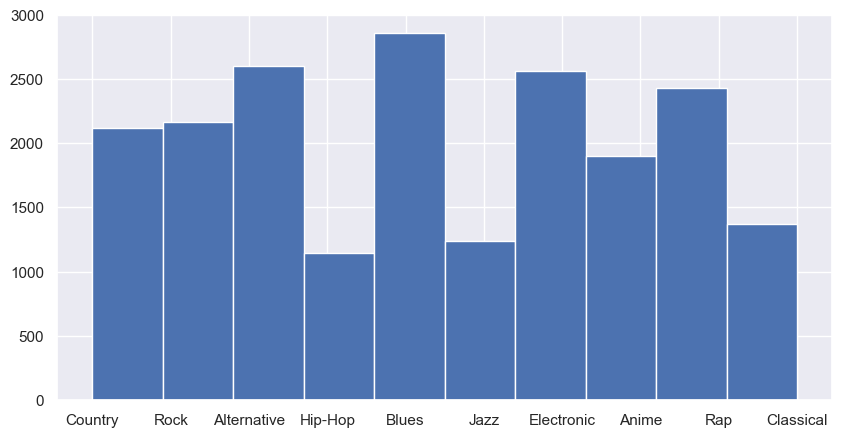

In [13]:
print(data_train['music_genre'].value_counts())
data_train['music_genre'].hist(figsize=(10, 5))

Есть пропуски в данных с ними будем работать внутри pipeline.

**Вывод этапа:**
- Провдена загрузка и проверка данных на пропуски и дубликаты (устранены).
- Проведена проверка корреляций признаков друг с другом, где выделены сильные корреляции у acousticness с *energy* и *loudness*, energy с *loudness*, *danceability* с *energy* и *valence*, *таргет* с *loudness*, *energy*, *acousticness*, *danceability, instrumentalness*.
- Исследовано распределение признаков.

## Построение моделей

### Catboost

Построим Catboost по имеющимся признакам, посмотрим скор на кросс-валидации с использованием градиентного бустинга.

In [14]:
X = data_train.drop(columns = ['music_genre', 'track_name'])
y = data_train['music_genre'].replace({'Blues':0,
                               'Alternative':1,
                               'Electronic':2,
                               'Rap':3,
                               'Rock':4,
                               'Country':5,
                               'Anime':6,
                               'Classical':7,
                               'Jazz':8,
                               'Hip-Hop':9})

cat_features = np.where((X.dtypes == 'object') | (X.dtypes == 'category'))[0]
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12345)

In [15]:
%%time
cross_val_score(CatBoostClassifier(random_state = 12345,
                           cat_features = cat_features,
                           auto_class_weights='Balanced',
                           logging_level = 'Silent',
                            max_depth = 7, iterations = 200),
                            X,
                            y,
                            cv=skf,
                            scoring='f1_micro').mean()

Wall time: 2min 45s


0.43990568383397316

### RandomForest

Проведем обучение случайного леса с использованием гиперпараметров.

In [16]:
%%time
model = RandomForestClassifier(random_state = 12345, class_weight = "balanced")
enc = TargetEncoder()

pipe = Pipeline(steps=[("enc", enc), ("RF", model)])
params = {"RF__n_estimators" : np.arange(120, 241, 10),
          "RF__max_depth" : np.arange(20, 41, 10)}
gs_1 = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = 'f1_micro',
                    refit = True,
                    cv = skf,
                    verbose = 2,
                    error_score="raise")
gs_1.fit(X, y)
gs_1.best_score_

Fitting 3 folds for each of 39 candidates, totalling 117 fits
[CV] END .............RF__max_depth=20, RF__n_estimators=120; total time=   5.3s
[CV] END .............RF__max_depth=20, RF__n_estimators=120; total time=   4.3s
[CV] END .............RF__max_depth=20, RF__n_estimators=120; total time=   4.3s
[CV] END .............RF__max_depth=20, RF__n_estimators=130; total time=   4.3s
[CV] END .............RF__max_depth=20, RF__n_estimators=130; total time=   4.3s
[CV] END .............RF__max_depth=20, RF__n_estimators=130; total time=   4.3s
[CV] END .............RF__max_depth=20, RF__n_estimators=140; total time=   4.8s
[CV] END .............RF__max_depth=20, RF__n_estimators=140; total time=   4.8s
[CV] END .............RF__max_depth=20, RF__n_estimators=140; total time=   6.9s
[CV] END .............RF__max_depth=20, RF__n_estimators=150; total time=   6.6s
[CV] END .............RF__max_depth=20, RF__n_estimators=150; total time=   4.9s
[CV] END .............RF__max_depth=20, RF__n_e

[CV] END .............RF__max_depth=40, RF__n_estimators=190; total time=   6.1s
[CV] END .............RF__max_depth=40, RF__n_estimators=200; total time=   6.4s
[CV] END .............RF__max_depth=40, RF__n_estimators=200; total time=   6.7s
[CV] END .............RF__max_depth=40, RF__n_estimators=200; total time=   6.5s
[CV] END .............RF__max_depth=40, RF__n_estimators=210; total time=   6.8s
[CV] END .............RF__max_depth=40, RF__n_estimators=210; total time=   6.7s
[CV] END .............RF__max_depth=40, RF__n_estimators=210; total time=   6.7s
[CV] END .............RF__max_depth=40, RF__n_estimators=220; total time=   7.0s
[CV] END .............RF__max_depth=40, RF__n_estimators=220; total time=   7.0s
[CV] END .............RF__max_depth=40, RF__n_estimators=220; total time=   7.0s
[CV] END .............RF__max_depth=40, RF__n_estimators=230; total time=   7.3s
[CV] END .............RF__max_depth=40, RF__n_estimators=230; total time=   7.3s
[CV] END .............RF__ma

0.4626584907598376

In [17]:
gs_1.best_params_

{'RF__max_depth': 20, 'RF__n_estimators': 230}

### LogisticRegression

In [18]:
%%time
ct = ColumnTransformer([('scale', StandardScaler(),
                         make_column_selector(dtype_include=np.number)),
                        ('onehot', OneHotEncoder(drop = 'first'),
                         [column for column in X.columns if X[column].dtype == 'object'])])

model = LogisticRegression(random_state = 12345,
                           class_weight='balanced',
                           multi_class='ovr',
                           solver='liblinear',
                           penalty='l1')

pipe = Pipeline(steps=[("ct", ct), ("LR", model)])
params = {"LR__C" : np.arange(0.1, 2.01, 0.1)}

gs_2 = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = 'f1_micro',
                    refit = True,
                    cv = 3,
                    verbose = 2,
                    error_score="raise")
gs_2.fit(X, y)
gs_2.best_score_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................................LR__C=0.1; total time=   1.5s
[CV] END ..........................................LR__C=0.1; total time=   0.9s
[CV] END ..........................................LR__C=0.1; total time=   1.8s
[CV] END ..........................................LR__C=0.2; total time=   2.0s
[CV] END ..........................................LR__C=0.2; total time=   1.4s
[CV] END ..........................................LR__C=0.2; total time=   2.2s
[CV] END ..........................LR__C=0.30000000000000004; total time=   2.4s
[CV] END ..........................LR__C=0.30000000000000004; total time=   1.6s
[CV] END ..........................LR__C=0.30000000000000004; total time=   2.7s
[CV] END ..........................................LR__C=0.4; total time=   3.1s
[CV] END ..........................................LR__C=0.4; total time=   1.9s
[CV] END .......................................

0.3915070117363819

**Вывод этапа:**
- Проведено разделение данных на целевой признак и атрибуты.
- Обучены модели со значениями метрики *f1* `Catboost` = 0.44, `RandomForest` = 0.46, `LogisticRegression` = 0.4.

Наилучший результат показал Случайный лес с подбором гиперпараметров.

### Pipeline

Построим pipeline для обучения моделей.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

num_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

#### Catboost

In [20]:
%%time
cbc = CatBoostClassifier(
    thread_count=4,
    random_strength=1,
    max_ctr_complexity=1,
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=300,
    early_stopping_rounds=10,
    depth=4,
    border_count=10,
    bootstrap_type='Bayesian'
)

cbc_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', cbc)
])

cbc_pipeline.fit(X_train, y_train)
y_pred = cbc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

0:	learn: 2.2033948	total: 18.9ms	remaining: 5.65s
1:	learn: 2.1387089	total: 34.8ms	remaining: 5.19s
2:	learn: 2.0821805	total: 49.3ms	remaining: 4.88s
3:	learn: 2.0303935	total: 65.2ms	remaining: 4.82s
4:	learn: 1.9964224	total: 80.5ms	remaining: 4.75s
5:	learn: 1.9576379	total: 98.8ms	remaining: 4.84s
6:	learn: 1.9315950	total: 113ms	remaining: 4.74s
7:	learn: 1.9046614	total: 130ms	remaining: 4.74s
8:	learn: 1.8777345	total: 152ms	remaining: 4.93s
9:	learn: 1.8574760	total: 169ms	remaining: 4.89s
10:	learn: 1.8364352	total: 187ms	remaining: 4.91s
11:	learn: 1.8159351	total: 208ms	remaining: 5s
12:	learn: 1.7961978	total: 226ms	remaining: 5s
13:	learn: 1.7767821	total: 254ms	remaining: 5.18s
14:	learn: 1.7621210	total: 277ms	remaining: 5.27s
15:	learn: 1.7480101	total: 298ms	remaining: 5.29s
16:	learn: 1.7351328	total: 323ms	remaining: 5.37s
17:	learn: 1.7230056	total: 341ms	remaining: 5.34s
18:	learn: 1.7107205	total: 366ms	remaining: 5.42s
19:	learn: 1.7017149	total: 394ms	remaini

161:	learn: 1.3828452	total: 3.6s	remaining: 3.07s
162:	learn: 1.3819617	total: 3.63s	remaining: 3.05s
163:	learn: 1.3813397	total: 3.65s	remaining: 3.02s
164:	learn: 1.3807480	total: 3.66s	remaining: 3s
165:	learn: 1.3799905	total: 3.68s	remaining: 2.97s
166:	learn: 1.3791685	total: 3.7s	remaining: 2.95s
167:	learn: 1.3783792	total: 3.72s	remaining: 2.92s
168:	learn: 1.3773804	total: 3.75s	remaining: 2.9s
169:	learn: 1.3765603	total: 3.77s	remaining: 2.88s
170:	learn: 1.3758004	total: 3.79s	remaining: 2.86s
171:	learn: 1.3745888	total: 3.81s	remaining: 2.83s
172:	learn: 1.3734876	total: 3.84s	remaining: 2.82s
173:	learn: 1.3726043	total: 3.86s	remaining: 2.8s
174:	learn: 1.3715936	total: 3.88s	remaining: 2.77s
175:	learn: 1.3705999	total: 3.9s	remaining: 2.75s
176:	learn: 1.3700474	total: 3.92s	remaining: 2.72s
177:	learn: 1.3691025	total: 3.94s	remaining: 2.7s
178:	learn: 1.3683169	total: 3.96s	remaining: 2.67s
179:	learn: 1.3672670	total: 3.98s	remaining: 2.65s
180:	learn: 1.3663824

#### LogisticRegression

In [21]:
%%time
lr = LogisticRegression(tol=0.01, solver='liblinear', penalty='l1', C=0.1)
lr_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', lr)
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.43
Wall time: 2.03 s


#### RandomForest

In [22]:
%%time
rfc = RandomForestClassifier(n_estimators=300, max_depth=10)

rfc_pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', rfc)
])

rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.44
Wall time: 19.8 s


**Вывод этапа:**
Обучены модели с использованием pipeline и результатами.
- CatBoost: 0.46
- LogisticRegression: 0.43
- RandomForest: 0.44

В целом результаты значительно выше, чем при обучении без пайплайна. Наилучший результат у Catboost.

## Вывод

Итак, имеются данные музыкальный стриминговый сервис "МиФаСоль", необходимо разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

На этапе подготовки 
- Провдена загрузка и проверка данных на пропуски и дубликаты (устранены).
- Проведена проверка корреляций признаков друг с другом, где выделены сильные корреляции у acousticness с *energy* и *loudness*, energy с *loudness*, *danceability* с *energy* и *valence*, *таргет* с *loudness*, *energy*, *acousticness*, *danceability, instrumentalness*.
- Исследовано распределение признаков.

Для обучение выбраны три модели. Сначало решено построить модели без использования *pipeline*. Модели показали следующие метрики *f1 micro* `Catboost` = 0.44, `RandomForest` = 0.46, `LogisticRegression` = 0.4.

Наилучший результат показал Случайный лес с подбором гиперпараметров.

Далее обучены модели с *pipeline*, и получены результаты:
- CatBoost: 0.46
- LogisticRegression: 0.43
- RandomForest: 0.44

В целом результаты значительно выше, чем при обучении без пайплайна.

Лучшей моделью оказался `Catboost c Pipeline`.